This notebook is designed to demonstrate how to produce a range of plots for airborne EM (line data) and SNMR (point data) on a vertical section. The requirements here are for the AEM inversion data to be in netcdf format as generated by the geophys_utils netcdf conversion tool and for the SNMR data to be in a sptialite database.

Neil Symington
neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [9]:
import netCDF4
from geophys_utils._netcdf_line_utils import NetCDFLineUtils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.patches import Rectangle
import pandas as pd
import importlib
from hydrogeol_utils.plotting_utils import ConductivitySectionPlot
import hydrogeol_utils.plotting_utils as plot_utils
from geophys_utils._transect_utils import coords2distance
from hydrogeol_utils import SNMR_utils
import time
import os
import sqlalchemy as db
from sqlite3 import dbapi2 as sqlite

In [3]:
# First we will deomstrate some straight AEM plotting

# Open netcdf files

ncdir = r'\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\OrdBonaparte_nbc_borehole_constrained\delivered_03_12_18\netcdf'

# Open the file with the EM measurements
# Here we use the data response file provided by Niel Christensen
EM_path = os.path.join(ncdir,'OrdBon2019_DataResp_cord2dLogKeep.nc')
EM_dataset = netCDF4.Dataset(EM_path)


# Open the file with the conductivity values
# The conductivity model was a 2d correlated borehole
# constrained inversion done by Niel Christensen

cond_path = os.path.join(ncdir,'OrdBon2019_ModelExp_cord2dLogKeep.nc')
cond_dataset = netCDF4.Dataset(cond_path)

# Open the stochastically inverted rjMCMC
# AEM inversoin from GARJMCMCTDEM

#rj_path = r"C:\Users\symin\OneDrive\Documents\GA\AEM\rjmcmc.nc"
#rj_dataset = netCDF4.Dataset(rj_path)

In [4]:
# View datasets

print(EM_dataset)
print(cond_dataset)
#print(rj_dataset)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Dataset read from ASEG-GDF file OrdBon2019_DataResp_cord2dLogKeep.dat
    Conventions: CF-1.6,ACDD-1.3
    featureType: trajectory
    geospatial_vertical_min: -6.44
    geospatial_vertical_max: 183.83
    geospatial_vertical_units: m
    geospatial_vertical_resolution: point
    geospatial_vertical_positive: up
    history: Converted from ASEG-GDF file OrdBon2019_DataResp_cord2dLogKeep.dat using definitions file OrdBon2019_DataResp_cord2dLogKeep.dfn
    date_created: 2018-12-03T10:29:47.069712
    geospatial_east_resolution: point
    geospatial_north_resolution: point
    geospatial_east_min: 439425.0
    geospatial_east_max: 519593.2
    geospatial_east_units: m
    geospatial_north_min: 8272445.8
    geospatial_north_max: 8371327.5
    geospatial_north_units: m
    geospatial_bounds: POLYGON((497426.3000 8272445.8000, 462013.2000 8307557.2000, 458094.8000 8312039.8000, 457222.0000 83143

In [5]:
# airborne EM inversions and data are typically visualised on a line by line basis

# To utilise the geophys_utils for line data create a NetCDFLineUtils for each dataset

EM_line_utils = NetCDFLineUtils(EM_dataset)
cond_line_utils = NetCDFLineUtils(cond_dataset)

# Display the lines for the conductivity mode

lines = cond_line_utils.line
print(lines)

[100102 100202 100302 100401 100501 100601 100701 100801 100901 101001
 101102 101202 101301 101402 101502 101602 101702 101801 101901 102001
 102101 102102 102201 102301 102401 102501 102601 102701 102801 102802
 102901 103001 103101 103201 103301 103302 103401 103501 103601 103701
 103801 103901 104001 104101 104201 104301 104401 104501 104601 104701
 104801 104901 105001 105101 105201 105301 105401 105501 105601 105701
 105801 105901 106001 106101 106201 106301 106401 106501 106601 106701
 106801 106901 107001 107101 107201 107301 107401 107501 107601 107701
 107702 107801 107901 108001 108101 108201 108301 108401 108501 108502
 108601 108701 108801 108901 108902 109001 109101 109201 109301 109302
 109401 109501 109601 500102 500201 500301 500401 500501 500601 912001
 912002 912003 912004 912005 912006 912007]


In [6]:
# Create an instance of plots
plots = ConductivitySectionPlot(cond_dataset, EM_dataset)

# Define some key variables which we want to inteprolate

plots.conductivity_variables = ['conductivity', 'data_residual', 'tx_height_measured', 'depth_of_investigation']

plots.EM_varibles  = ['data_values_by_low_moment_gate', 'data_values_by_high_moment_gate', 
                       'data_response_by_low_moment_gate', 'data_response_by_high_moment_gate']

# Define the hdf5 output directory
hdf5_dir =  r"C:\GA\OB_AEM\inversions\OrdBon2019_grids_hdf5"

# Define the resolution of th sections
xres, yres = 20., 2.

# Here we are plotting every line and saving the outputs as hdf5 files
# Given some of the computing time overhead of gridding the sections it may be preferrable to save
# the output to allow faster plotting
#plots.grid_vars(xres = xres, yres =yres, lines=lines, conductivity_variables = section_vars['conductivity_model'],
#                  data_variables = section_vars['EM_data'],
#                     layer_subdivisions = 4, resampling_method = 'linear',
#                     save_hdf5 = True, hdf5_dir = hdf5_dir,
#                     overwrite_hdf5 = True, return_dict = False)


In [7]:
# Now we will plot a section from one of the hdf5 file we produced earlier

line = 105501

# The sections will be plotted with a number of panels with a shared horizontal axis
# To define what we will plot for each panel we use a dictionary that define the variable
# to plot (which needs to be inluded in the interpolated) and the 

plot_settings = {'figsize': (20, 11), 'dpi': 300}

panel_settings = {'panel_1': {'variable': 'data_values_by_high_moment_gate',
                              'plot_type': 'multi_line',
                             'panel_kwargs': {'title': 'high moment data',
                                             'ylabel': 'dB/dT (V/(A.turns.m^4))'},
                             'height_ratio': 3},
                  
                 'panel_2': {'variable': 'data_values_by_low_moment_gate',
                             'plot_type': 'multi_line',
                             'panel_kwargs': {'title': 'low moment data',
                                              'ylabel': 'dB/dT (V/(A.turns.m^4))'},
                             'height_ratio': 3},
                  
                 'panel_3': {'variable': 'data_residual',
                             'plot_type': 'line',
                             'panel_kwargs': {'title': 'data residual', 'color': 'black',
                                              'ylabel': 'data residual',
                                              'legend': False},
                             'height_ratio': 1},
                  
                 'panel_4': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 500, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': False, 'vmin': 0, 'vmax': 0.1,
                                             'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 5},
                  
                 'panel_5': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 500, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': 0.001, 'vmax': 0.1,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 5}}
                
# Extract the data set from the path
hdf5_dir =  r"C:\GA\OB_AEM\inversions\OrdBon2019_grids_hdf5"
file = os.path.join(hdf5_dir, str(line) + '.hdf5')

# We will save this plot to a directory

outdir = r'C:\GA\OB_AEM\inversions\sections_cor2dlog'

#fig, ax_array = plt.subplots(len(panel_settings), 1, sharex=True, figsize=(20, 11),
#                                     gridspec_kw={'height_ratios':
#                                                  plots.unpack_plot_settings(panel_settings,'height_ratio')})

#plots.plot_conductivity_section_from_hdf5file(file, ax_array, plot_settings, panel_settings, save_fig = True,
#                                  outfile = os.path.join(outdir, str(line) + '.png'))


In [13]:
# Otherwise plotting can be done automatically stright from a gridded dictionary
# if no hdf5 file exists

# We will use the same panel settings


plots.conductivity_variables = ['conductivity', 'data_residual', 'tx_height_measured', 'depth_of_investigation']

plots.EM_variables  = ['data_values_by_low_moment_gate', 'data_values_by_high_moment_gate']


# Grid the line but leave it in memory
gridded_vars = plots.grid_variables(xres = 20., yres =2., lines=105501, layer_subdivisions = 4, resampling_method = 'linear',
                               save_hdf5 = False, return_dict = True)

In [14]:
gridded_vars[105501].keys()

dict_keys(['conductivity', 'layer_top_depth', 'grid_distances', 'grid_elevations', 'data_residual', 'tx_height_measured', 'depth_of_investigation', 'easting', 'northing', 'elevation', 'data_values_by_low_moment_gate', 'data_values_by_high_moment_gate'])

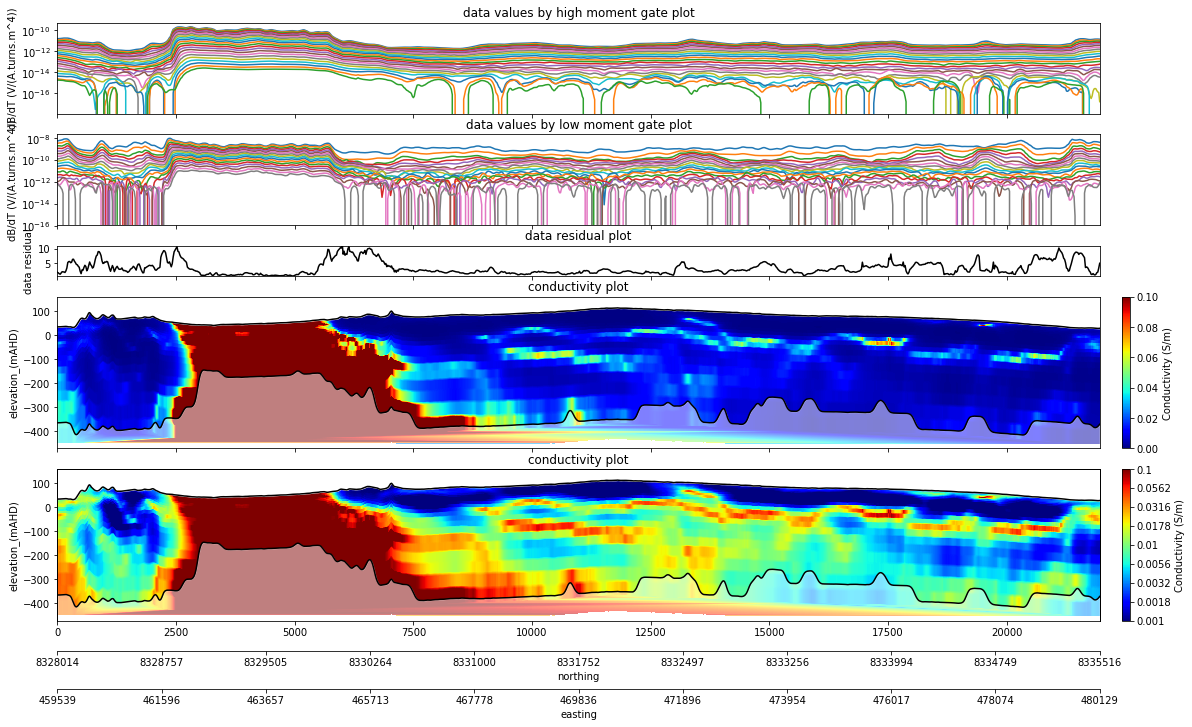

In [15]:
# PLot the figure just within the editor
fig, ax_array = plt.subplots(len(panel_settings), 1, sharex=True, figsize=(20, 11),
                                     gridspec_kw={'height_ratios':
                                                  plot_utils.unpack_plot_settings(panel_settings,'height_ratio')})

# Now plot
plot_utils.plot_conductivity_section(ax_array, gridded_vars[line], plot_settings, panel_settings, save_fig = False,
                                  outfile = os.path.join(outdir, str(line) + '.png'))

In [16]:
# Next we want to add other data over the conductivity sections

# Import SNMR data

# Connect to the SNMR database

DB_PATH = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\NMR\SNMR\East_Kimberley_SNMR.sqlite"
        
engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

connection = engine.connect()

query = 'SELECT a.*, s.mid_X, s.mid_Y FROM acquisitions as a JOIN sites as s on s.site_id=a.site_id;'

df_acquisitions = pd.read_sql_query(query, connection)

# Extract the acquisitions based on criteria

# Our first criteria will be an ordered list for how we preference
# the acquisition type

pulse_sequence_criteria = ['FID', 'T1', 'CPMG']

# Our first criteria is choosing the larger available pulse length

pulse_length_criteria = 'max'

acquisition_ids = SNMR_utils.choose_snmr_site_acquisition(df_acquisitions,
                                               pulse_sequence_criteria,
                                               pulse_length_criteria)

# Extract the inversion table for these acquisitions

cols = ['Depth_from', 'Depth_to', 'Mobile_water_content', 'Bound_water_content',
       'Total_water_content', 'site_id', 'acquisition_id', 'inversion_id']

df_inversions= SNMR_utils.extract_snmr_inversions(acquisition_ids, connection,
                                                  mask_below_doi = True)[cols]

# Join the SNMR inversions on acquisition and sites

df_inversions = df_inversions.merge(df_acquisitions, how='inner', left_on='acquisition_id',
                                    right_index=True)


C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Ad

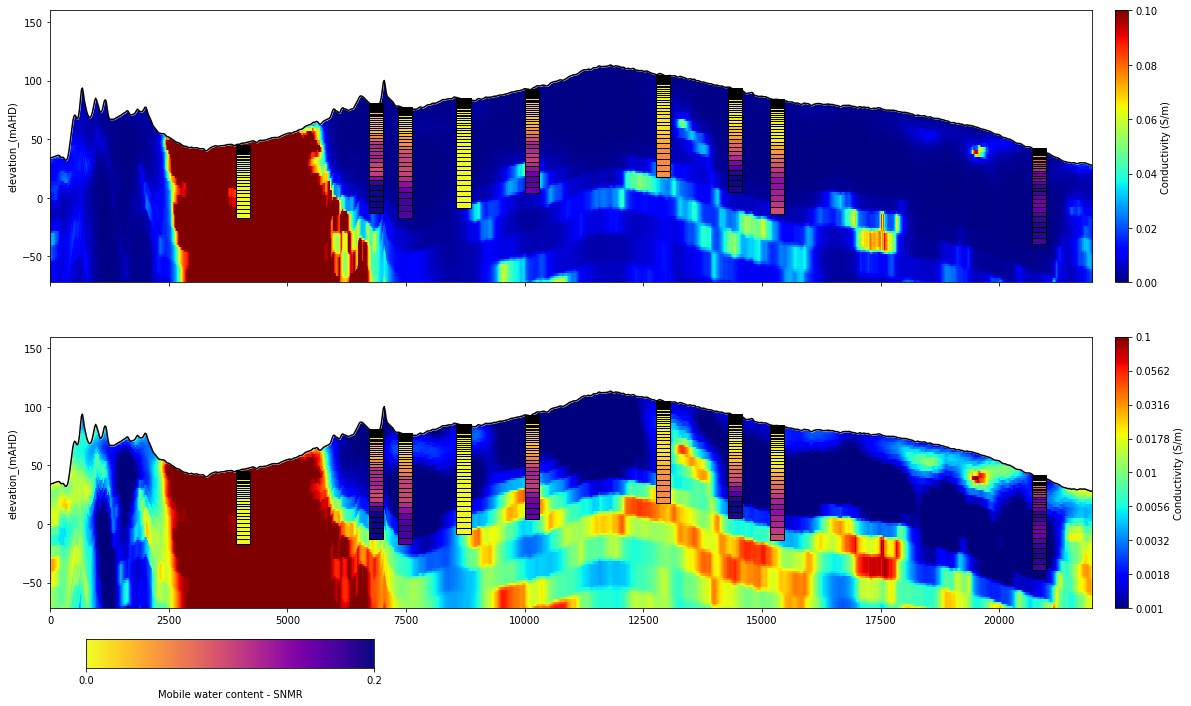

In [20]:


plot_settings = {'figsize': (20, 11), 'dpi': 300}

panel_settings = {'panel_1': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 100, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': False, 'vmin': 0, 'vmax': 0.1,
                                             'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 1},
                  
                 'panel_2': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 100, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': 0.001, 'vmax': 0.1,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 1}}


fig, ax_array = plt.subplots(len(panel_settings), 1, sharex=True, figsize=(20, 11),
                                     gridspec_kw={'height_ratios':
                                                  plot_utils.unpack_plot_settings(panel_settings,'height_ratio')})
for i, ax in enumerate(ax_array):
    # PLot a conductivity section
    plot_utils.plot_grid(ax, gridded_vars[105501], 'conductivity',
                    plot_utils.unpack_plot_settings(panel_settings, "panel_kwargs")[i])
    
    plot_utils.add_1d_layered_model(ax, df_inversions, gridded_vars[105501], plot_variable = 'Mobile_water_content',
                          xy_columns = ['mid_X', "mid_Y"], cmap = 'plasma_r', colour_stretch = [0,0.2], stick_thickness = 300.)
    
    # Add the new colourbar for the stick plot
    newax = fig.add_axes([0.15,0.05, 0.2, 0.2], anchor='SW', zorder=1)
    
    plot_utils.add_custom_colourbar(newax, 'plasma_r', 0,0.2, "Mobile water content - SNMR")

In [ ]:
# Now lets plot the rjmcmc inversion products for a particular line

# Create an instance of plots
plots_rj = ConductivitySectionPlot(rj_dataset)

# We will use the same panel settings

line = 105001

cond_vars = ['conductivity_mean', 'conductivity_p10', 'conductivity_p50', 'conductivity_p90',
            'conductivity_highestlikelihood', 'conductivity_lowestmisfit', 'changepoint']


# Grid the line but leave it in memory
gridded_vars = plots_rj.grid_vars(xres = 50., yres =2., lines=line,
                               conductivity_variables = cond_vars,
                               data_variables = None,
                               layer_subdivisions = 1, resampling_method = 'linear',
                               save_hdf5 = False, return_dict = True)


In [ ]:


plot_settings = {'figsize': (20, 11), 'dpi': 300}

panel_settings = {
                  
                 'panel_1': {'variable': 'conductivity_p50',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity median',
                                              'max_depth': 200, 'shade_doi': False, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': False, 'vmin': 0, 'vmax': 0.5,
                                             'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 1},
                  
                 'panel_2': {'variable': 'conductivity_highestlikelihood',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity highest likelihood',
                                              'max_depth': 200, 'shade_doi': False, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': 0.001, 'vmax': 0.5,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 1}}



# PLot the figure just within the editor
fig, ax_array = plt.subplots(len(panel_settings), 1, sharex=True, figsize=(20, 11),
                                     gridspec_kw={'height_ratios':
                                                  plots_rj.unpack_plot_settings(panel_settings,'height_ratio')})

# Now plot
plots_rj.plot_conductivity_section(ax_array, gridded_vars[line], plot_settings, panel_settings, save_fig = False,
                                  outfile = os.path.join(outdir, str(line) + '_rjmcmc.png'))

In [130]:
# Now we will plot a gridded section provided by GSI

def parse_gridded_conductivity_file(infile, header, null = 1e-08):
    """
    @param infile: path to an asci xyz file with gridded conductivity
    such as those supplied by CGI
    @param header: list of column names that should match keywords from 
    geophys_utils
    @param null: float of null values
    """
    # Save the data in a dictionary
    data = {}
    for i, item in enumerate(header):
        # Load the gridded column into the dictionary
        data[item] = np.loadtxt(infile, usecols = i)
        # Replace null values with np.nan
        mask = data[item] == null
        data[item][mask] = np.nan
    return data

# AS we know the structure of the data we can create a more usable
# where the variable (conductivity) is structured as a 2D
# array
def griddify_xyz(data):
    # Create a gridded data dictionary
    gridded_data = {}
    
    # Find the number of horizontal and vertical cells
    
    nvcells = len(np.unique(data['elevation']))
    nhcells = int(len(data['elevation'])/len(np.unique(data['elevation'])))
    
    # Create the grid
    
    cond = np.zeros(shape = (nvcells, nhcells),
                    dtype = data['conductivity'].dtype)
    
    # Now iterate through the conductivity and populate the array
    
    for i in range(nvcells):
        # Get the 2D array indices
        cond[i,:] = data['conductivity'][i*nhcells:(i+1)*nhcells]
    
    # Replace the entry
    gridded_data['conductivity'] = cond
    
    # Add the east, northing and elevation top to the dictionary
    gridded_data['easting'] = data['easting'][:nhcells]
    gridded_data['northing'] = data['northing'][:nhcells]
    gridded_data['grid_elevations'] = np.unique(data['elevation'])
    
    # rotate or flip the grids if need be
    if gridded_data['easting'][0] > gridded_data['easting'][-1]:
        reverse_line = True
    else:
        reverse_line = False
    
    if gridded_data['grid_elevations'][0] < gridded_data['grid_elevations'][-1]:
        flip_grid = True
    else:
        flip_grid = False
    
    if reverse_line:
        gridded_data['conductivity'] = np.fliplr(gridded_data['conductivity'])
        gridded_data['easting'] = gridded_data['easting'][::-1]
        gridded_data['northing'] = gridded_data['northing'][::-1]
    
    if flip_grid:
        gridded_data['conductivity'] = np.flipud(gridded_data['conductivity'])
        gridded_data['grid_elevations'] = gridded_data['grid_elevations'][::-1]
    # Calculate the distance along the line
    
    utm_coordinates = np.hstack((gridded_data['easting'].reshape([-1,1]),
                                 gridded_data['northing'] .reshape([-1,1])))
    
    gridded_data['grid_distances'] = coords2distance(utm_coordinates)
    
    # Estimate the ground elevation using the nan values
    
    elevation = np.zeros(shape = gridded_data['easting'].shape,
                        dtype = gridded_data['grid_elevations'].dtype)
    
    # Iterate through the cells and find the lowest elevation with data
    for i in range(gridded_data['conductivity'].shape[1]):
        try:
            idx = np.max(np.argwhere(np.isnan(gridded_data['conductivity'][:,i]))) + 1
            elevation[i] = gridded_data['grid_elevations'][idx]
        except ValueError:
            elevation[i] = np.max(gridded_data['grid_elevations'])
    
    # Add to dictionary
    gridded_data['elevation'] = elevation
    return gridded_data
        
        
    
        
        

In [74]:
infile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\CGI_OB_3D_AEM_models\delivered\20190211\Bonaparte_L105501_w_seismic_xyzzc\Bonaparte_L105501_w_seismic_xyzzc.txt"

CGI_conductivity = parse_gridded_conductivity_file(infile, ['easting', 'northing', 'elevation_centre',
                                                           'elevation', 'conductivity'], null=1e-08)

In [144]:
CGI_gridded_data = griddify_xyz(CGI_conductivity)

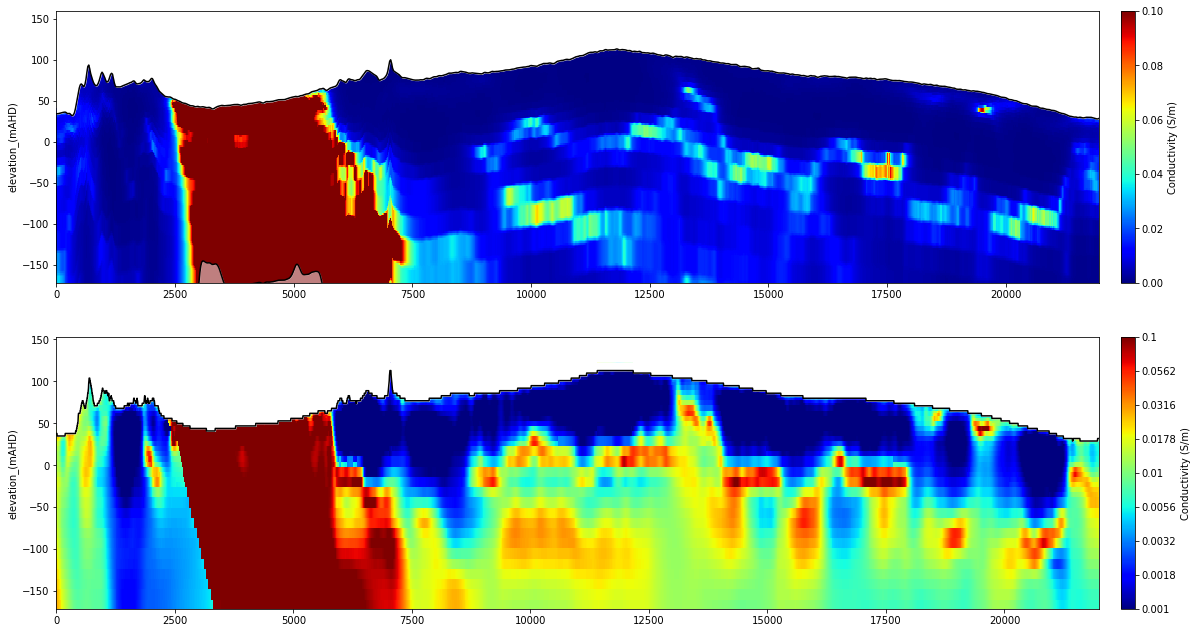

In [160]:
plot_settings = {'figsize': (10, 11), 'dpi': 300}

panel_settings = {'panel_1': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 200, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': False, 'vmin': 0, 'vmax': 0.1,
                                             'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 1},
                  
                 'panel_2': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 200, 'shade_doi': False, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': 0.001, 'vmax': 0.1,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 1}}


fig, ax_array = plt.subplots(len(panel_settings), 1, figsize=(20, 11),
                                     gridspec_kw={'height_ratios':
                                                  plots.unpack_plot_settings(panel_settings,'height_ratio')})

plots.plot_grid(ax_array[0], gridded_vars[105501], 'conductivity',
                    plots.unpack_plot_settings(panel_settings, "panel_kwargs")[0])

plots.plot_grid(ax_array[1], CGI_gridded_data, 'conductivity',
                    plots.unpack_plot_settings(panel_settings, "panel_kwargs")[1])
    

In [149]:
len(panel_settings)

2